## Motion Correction demo

This notebook demonstrates the various routines for motion correction in the CaImAn package. It demonstrates the usage of rigid and piecewise rigid motion correction on a two-photon calcium imaging dataset using the NoRMCorre algorithm [[1]](#normcorre), as well as several measures for quality assessment. This notebook should be interpreted more as a tutorial of the various methods. In practice, you can use either rigid or piecewise rigid motion correction depending on the motion of the dataset.

The dataset used in this notebook is provided by Sue Ann Koay and David Tank, Princeton University. This is a two photon calcium imaging dataset. For motion correction of one photon microendoscopic data the procedure is similar, with the difference, that the shifts are inferred on high pass spatially filtered version of the data. For more information check the demos for one photon data in the CaImAn package.

More information about the NoRMCorre algorithm can be found in the following paper:

<a name="normcorre"></a>[1] Pnevmatikakis, E.A., and Giovannucci A. (2017). NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data. Journal of Neuroscience Methods, 291:83-92 [[paper]](https://doi.org/10.1016/j.jneumeth.2017.07.031)

In [1]:
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging

from src.tools import get_images

SET = "set_01"
SAMPLE = "sample_000"

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

C:\Users\gt8mar\AppData\Local\Temp\ipykernel_18060\1935493016.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
C:\Users\gt8mar\AppData\Local\Temp\ipykernel_18060\1935493016.py:26: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')
        3079 [__init__.py:            <module>():47] [18060] Creating converter from 7 to 5
        3080 [__init__.py:            <module>():47] [18060] Creating converter from 5 to 7
        3081 [__init__.py:            <module>():47] [18060] Creating converter from 7 to 5
        3081 [__init__.py:            <module>():47] [18060] Creating converter from 5 to 7
        8862 [tpu_cluster_resolver.py:            <module>():32] [18060] Falling back to TensorFlow client; we recommended you install the Cl

First download the file and load it in memory to view it. Note that it is not necessary to load the file in memory in order to perform motion correction. Here we load it to inspect it. Viewing the file occurs with OpenCV and will a open a new window. **To exit click on the video and press q.**

The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fname` variable as a list.

In [2]:
from caiman.paths import caiman_datadir
print(caiman_datadir())

fnames = 'Sue_2x_3000_40_-46_dust.tif'
# fnames = 'Sue_2x_3000_40_-46.tif'
# fnames = 'set_01_sample_000_stack_downsample7test.tif'
fnames = [download_demo(fnames)]     # the file will be downloaded if it doesn't already exist


m_orig = cm.load_movie_chain(fnames)
downsample_ratio = .2  # motion can be perceived better when downsampling in time
m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=30, magnification=2)   # play movie (press q to exit)

       17834 [utils.py:       download_demo():117] [18060] File Sue_2x_3000_40_-46_dust.tif already downloaded


C:\Users\gt8mar\caiman_data
C:\Users\gt8mar\caiman_data


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
       18149 [movies.py:              resize():1084] [18060] reshaping along z


Now set some parameters that are used for motion correction.

In [3]:
max_shifts = (25, 25)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
num_frames_split = 50  # length in frames of each chunk of the movie (to be processed in parallel)
max_deviation_rigid = 10   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

Note that here the data presented here has been downsampled in space by a factor of 2 to reduce the file size. As a result the spatial resolution is coarser here (around 2 microns per pixel). If we were operating at the original resolution, several of the parameters above, e.g., ```max_shifts, strides, overlaps, max_deviation_rigid```, could have been larger by a factor of 2.

In [4]:
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1' 

###### Motion correction is performed in parallel on chunks taken across times.

We first need to start a cluster. The default backend mode for parallel processing is through the multiprocessing package. To make sure that this package is viewable from everywhere before starting the notebook these commands need to be executed from the terminal (in Linux and Windows):
```bash
   export MKL_NUM_THREADS=1
   export OPENBLAS_NUM_THREADS=1 
   ```

In [5]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

We first need to create a motion correction object with the parameters specified above. We pass directly its input arguments in the constructor below. Alternatively, we can use the `params` object and construct it by passing the arguments of `params.motion`. See the notebook `demo_pipeline.ipynb` for an example of this usage.

In [6]:
# create a motion correction object
mc = MotionCorrect(fnames, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)

<h1> Rigid motion correction</h1>
<p> The original file exhibits a lot of motion. In order to correct for it we are first trying a simple rigid motion correction algorithm. This has already been selected by setting the parameter `pw_rigid=False` during the construction of the `MotionCorrect` object. The algorithm first creates a template by averaging frames from the video. It then tries to match each frame to this template. In addition the template will get updated during the matching process, resulting in a single precise template that is used for subpixel registration.  </p>
<img src="../../docs/img/rigidcorrection.png" />

In [ ]:
# Not in original file: choose template file
files = cm.load(fnames)
template = files[659]
print(template.shape)

In [7]:
#%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)                  # template=template

       53630 [motion_correction.py:motion_correct_rigid():297] [18060] Entering Rigid Motion Correction
       53630 [motion_correction.py:motion_correct_rigid():298] [18060] 296.0
       53686 [movies.py:      extract_shifts():357] [18060] min_val in extract_shifts: -296.0
       53687 [movies.py:      extract_shifts():358] [18060] Movie average is negative. Removing 1st percentile.
       53689 [movies.py:      extract_shifts():376] [18060] Movie average is negative. Removing 1st percentile.
       53721 [movies.py:        apply_shifts():454] [18060] cubic interpolation
       53775 [movies.py:      extract_shifts():357] [18060] min_val in extract_shifts: -296.0
       53776 [movies.py:      extract_shifts():358] [18060] Movie average is negative. Removing 1st percentile.
       53779 [movies.py:      extract_shifts():376] [18060] Movie average is negative. Removing 1st percentile.
       53810 [movies.py:        apply_shifts():454] [18060] cubic interpolation


fname_cur is C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust.tif
self.indices is (slice(None, None, None), slice(None, None, None))
the file name is: C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust.tif
dims is (170, 170)
Time is 3000


       53866 [movies.py:      extract_shifts():357] [18060] min_val in extract_shifts: -296.0
       53867 [movies.py:      extract_shifts():358] [18060] Movie average is negative. Removing 1st percentile.
       53869 [movies.py:      extract_shifts():376] [18060] Movie average is negative. Removing 1st percentile.
       53902 [movies.py:        apply_shifts():454] [18060] cubic interpolation
       53937 [motion_correction.py:motion_correct_batch_rigid():2879] [18060] Adding to movie 296.0
       53938 [motion_correction.py:motion_correct_batch_rigid():2885] [18060] 0
       53938 [motion_correction.py:motion_correct_batch_rigid():2889] [18060] saving!
       53951 [motion_correction.py:motion_correction_piecewise():3162] [18060] Number of Splits: 14
       53953 [motion_correction.py:motion_correction_piecewise():3200] [18060] Saving file as C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust_rig__d1_170_d2_170_d3_1_order_F_frames_3000_.mmap
       53955 [motion_corr

the file name is: C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust.tif


       75071 [motion_correction.py:motion_correction_piecewise():3221] [18060] ** Finished parallel motion correction **


did we do it


The motion corrected file is automatically save as memory mapped file in the location given by `mc.mmap_file`. The rigid shifts are also save in `mc.shifts_rig`. 

  0%|          | 0/1 [00:00<?, ?it/s]      819239 [movies.py:                load():1728] [18060] loading mmap file in memory
      819535 [movies.py:                load():1731] [18060] mmap
100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


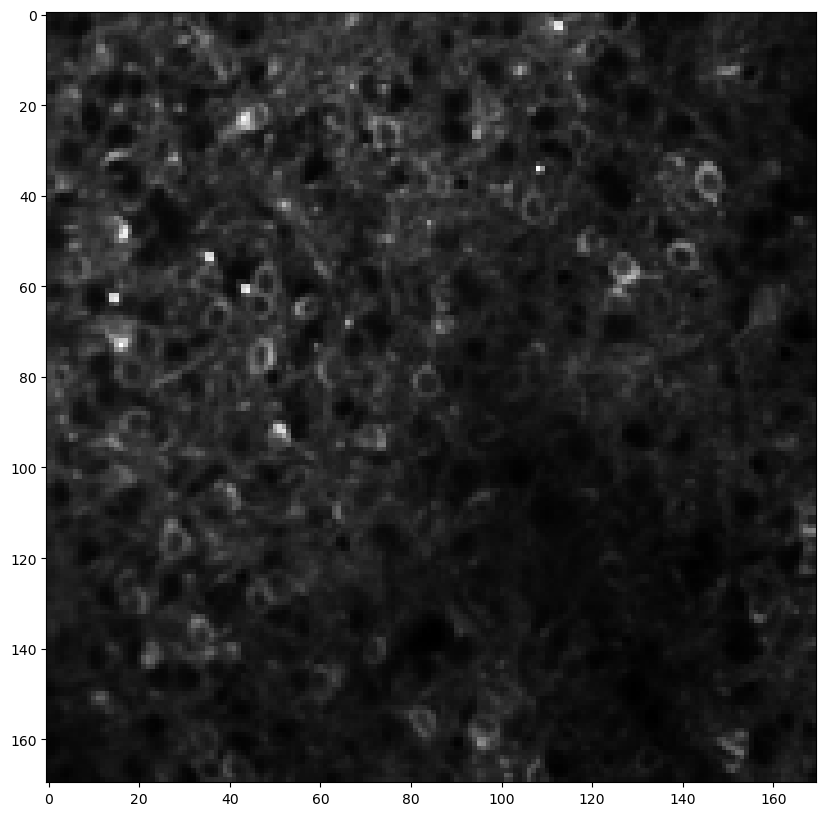

In [21]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(int)
#%% visualize templates
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray')

In [23]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=4, bord_px = 0*bord_px_rig) # press q to exit

     1122460 [movies.py:              resize():1084] [18060] reshaping along z


plot the shifts computed by rigid registration

Text(0, 0.5, 'pixels')

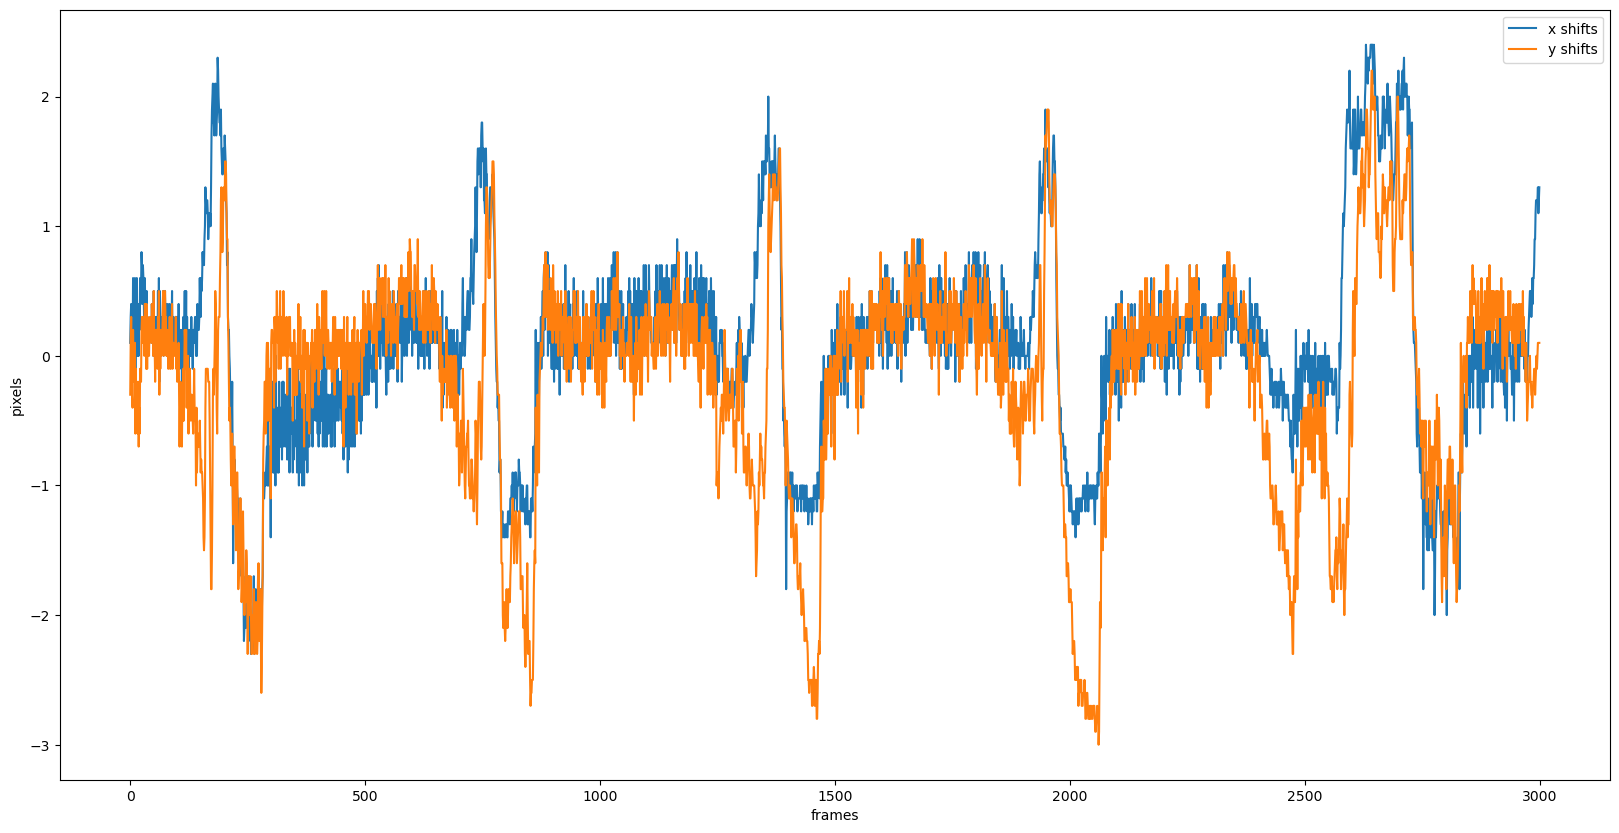

In [10]:
#%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

## Piecewise rigid registration
While rigid registration corrected for a lot of the movement, there is still non-uniform motion present in the registered file. To correct for that we can use piece-wise rigid registration **directly in the original file** by setting `mc.pw_rigid=True`. As before the registered file is saved in a memory mapped format in the location given by `mc.mmap_file`.

In [13]:
%%capture
#%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=4,bord_px = bord_px_rig)

      266695 [motion_correction.py:motion_correct_batch_pwrigid():3007] [18060] Adding to movie 296.0
      266696 [motion_correction.py:motion_correct_batch_pwrigid():3010] [18060] 0
      266697 [motion_correction.py:motion_correct_batch_pwrigid():3020] [18060] saving mmap of C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust.tif
      266710 [motion_correction.py:motion_correction_piecewise():3162] [18060] Number of Splits: 14
      266741 [motion_correction.py:motion_correction_piecewise():3200] [18060] Saving file as C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust_els__d1_170_d2_170_d3_1_order_F_frames_3000_.mmap
      266742 [motion_correction.py:motion_correction_piecewise():3206] [18060] Processing: frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58 

Now concatenate all the movies (raw, rigid, and pw-rigid) for inspection

In [24]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=30, q_max=99.5, magnification=4, bord_px=bord_px_rig)

     1196257 [movies.py:              resize():1084] [18060] reshaping along z
     1196359 [movies.py:              resize():1084] [18060] reshaping along z
     1196593 [movies.py:              resize():1084] [18060] reshaping along z


From the movie we can see that pw-rigid registration corrected for the non uniform motion of the data. This was done by estimating different displacement vectors for the different patches in the FOV. This can be visualized by plotting all the computed shifts were a dispersion in the shifts in the y direction is apparent. In this case, the shifts along the two axes are stored in `mc.x_shifts_els` and `mc.y_shifts_els`, respectively.

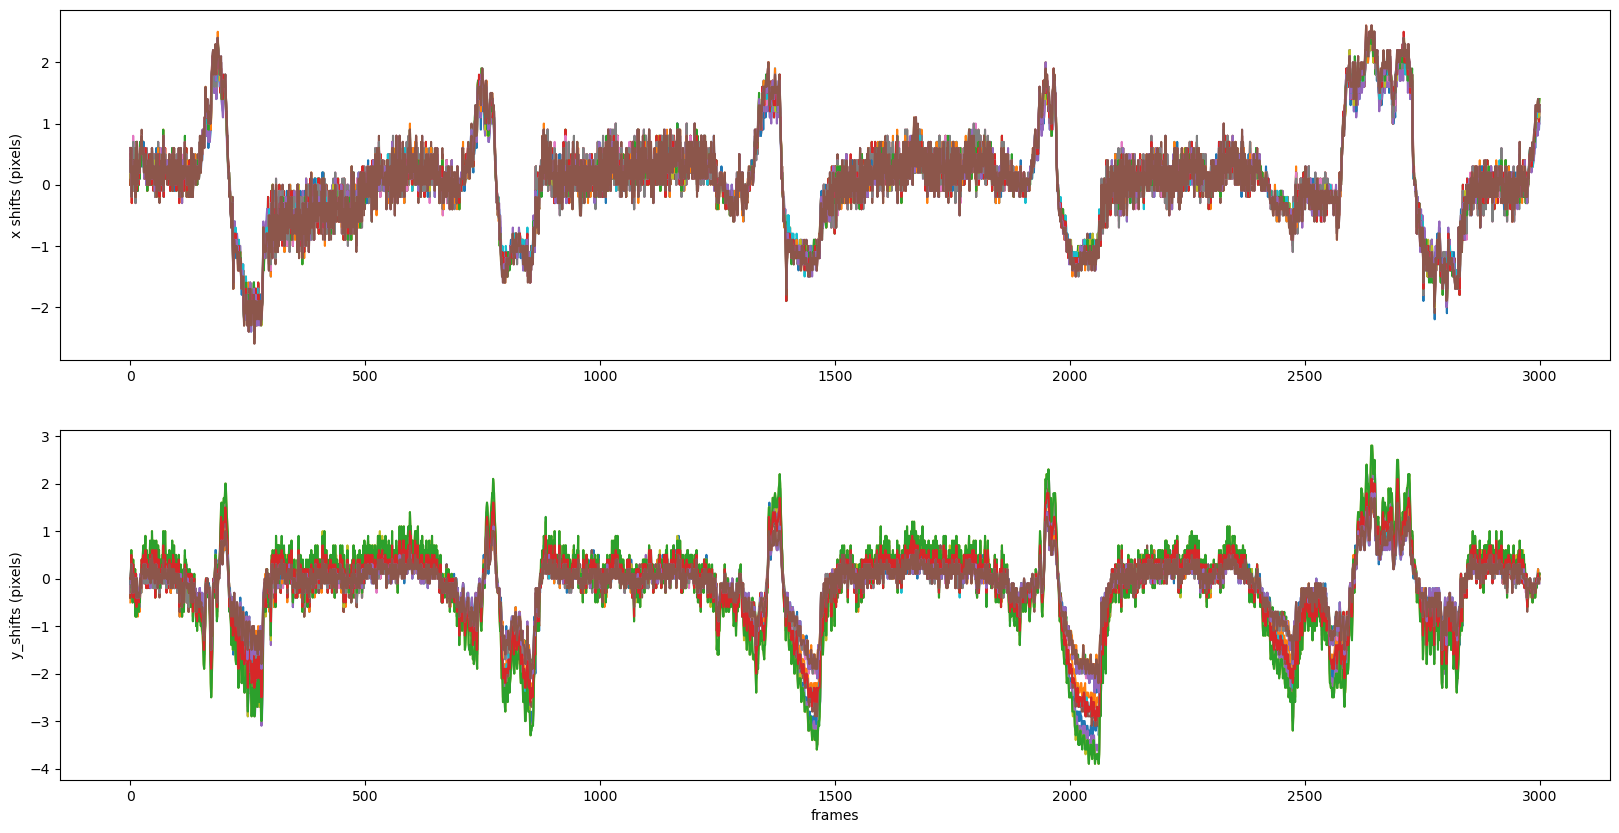

In [15]:
#%% visualize elastic shifts
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(int)

The improvement in performance can also be seen by a more crisp summary statistic image. Below we plot the correlation images for the three datasets.

c:\Users\gt8mar\miniconda3\envs\caiman\lib\site-packages\caiman\summary_images.py:217: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


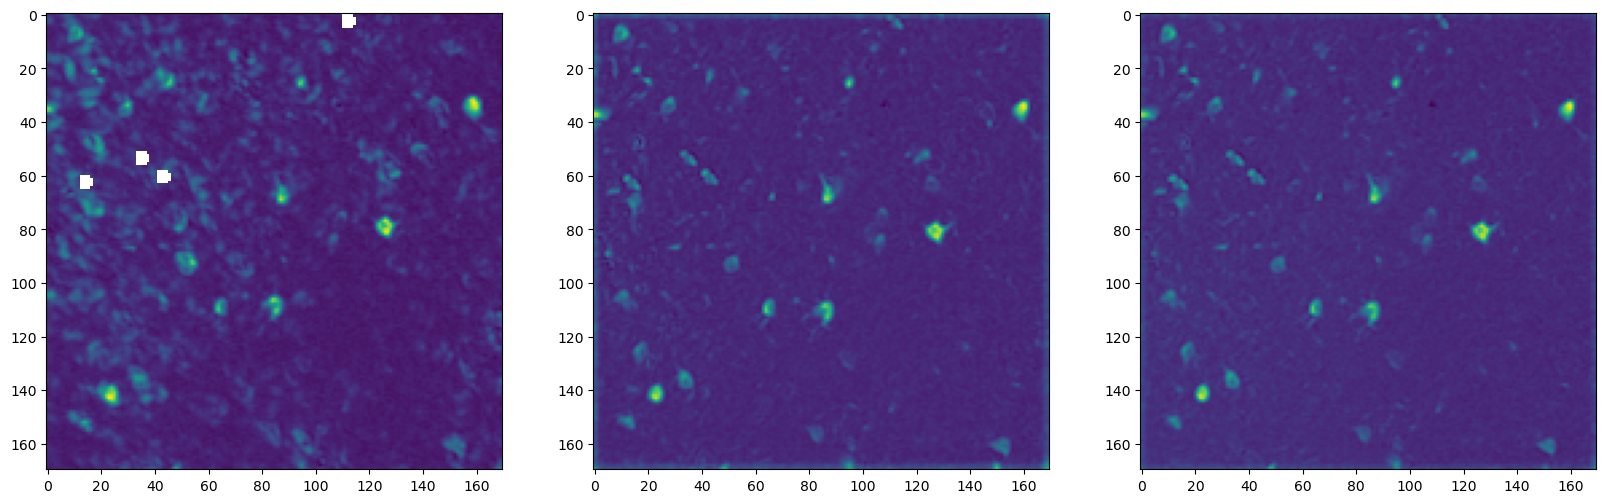

In [16]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

In [ ]:
# cm.stop_server(dview=dview) # stop the server

## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [17]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
# logging.disable

final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

      494366 [motion_correction.py:compute_metrics_motion_correction():2675] [18060] [4, -4, 4, -4]
      494467 [motion_correction.py:compute_metrics_motion_correction():2682] [18060] Local correlations..
      495471 [motion_correction.py:compute_metrics_motion_correction():2684] [18060] (3000, 162, 162)
      496479 [motion_correction.py:compute_metrics_motion_correction():2690] [18060] Compute Smoothness.. 
      496605 [motion_correction.py:compute_metrics_motion_correction():2696] [18060] Compute correlations.. 
      496605 [motion_correction.py:compute_metrics_motion_correction():2703] [18060] 0
      496641 [motion_correction.py:compute_metrics_motion_correction():2703] [18060] 100
      496674 [motion_correction.py:compute_metrics_motion_correction():2703] [18060] 200
      496703 [motion_correction.py:compute_metrics_motion_correction():2703] [18060] 300
      496732 [motion_correction.py:compute_metrics_motion_correction():2703] [18060] 400
      496769 [motion_correction.p

Plot correlation with mean frame for each dataset

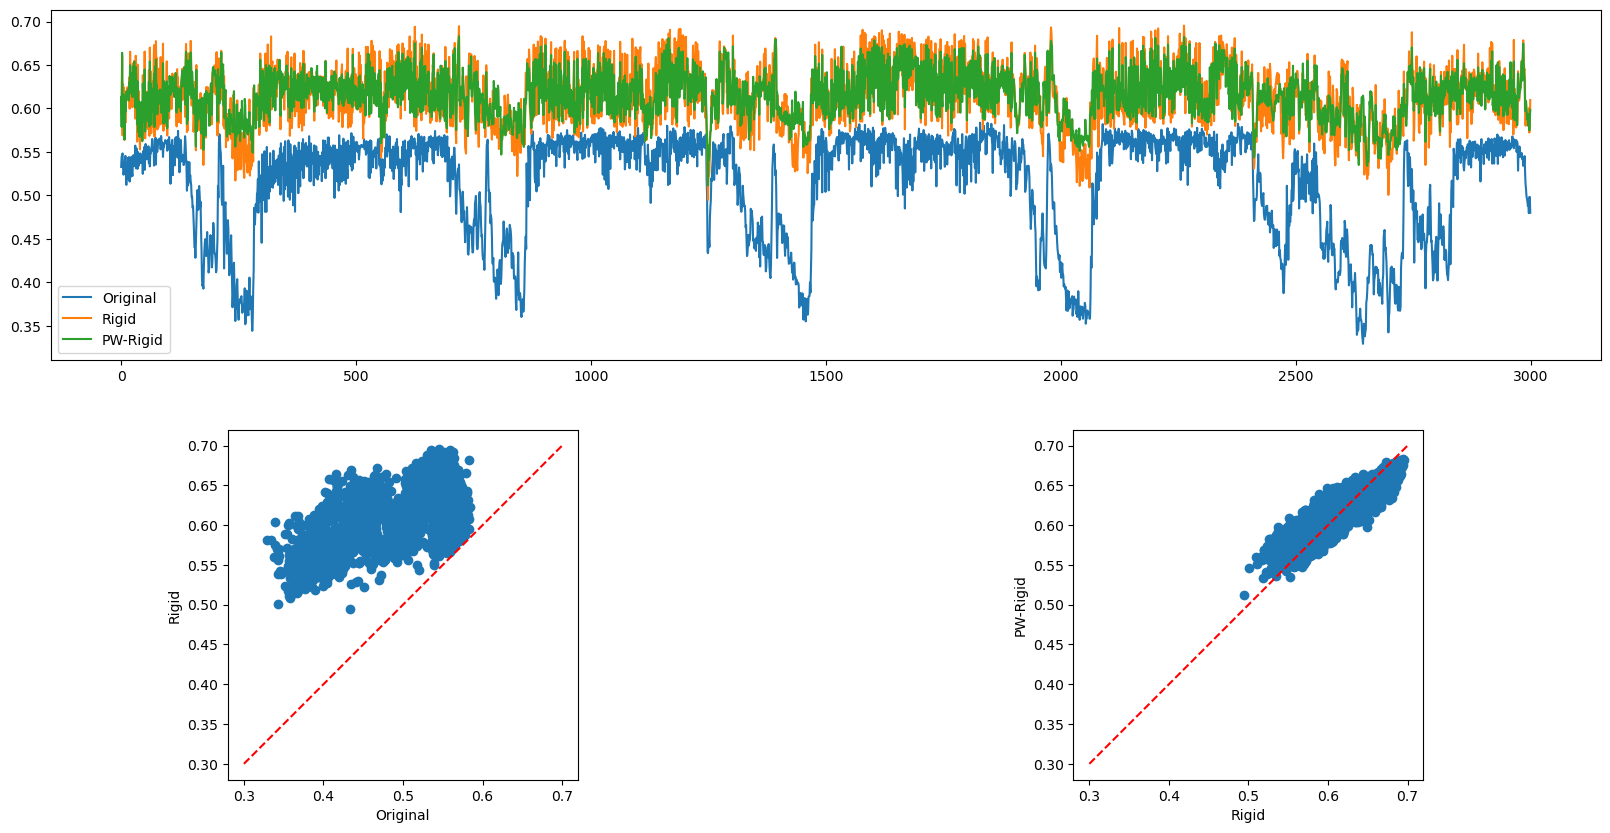

In [18]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');


In [19]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 2282
Crispness rigid: 2847
Crispness elastic: 2925


      559255 [movies.py:                load():1731] [18060] mmap


KeysView(<numpy.lib.npyio.NpzFile object at 0x000001EE94ADD720>)
C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust_els__d1_170_d2_170_d3_1_order_F_frames_3000__metrics.npz
14.445648+/-7.379455 ; 2925.5093 ; 5.231578709998985


      559646 [colorbar.py:_get_ticker_locator_formatter():857] [18060] locator: <matplotlib.ticker.AutoLocator object at 0x000001EE952A03D0>
      559662 [movies.py:                load():1731] [18060] mmap


KeysView(<numpy.lib.npyio.NpzFile object at 0x000001EE95283A00>)
C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust_rig__d1_170_d2_170_d3_1_order_F_frames_3000__metrics.npz
22.00029+/-13.845264 ; 2847.6846 ; 5.304776775184123


      560049 [colorbar.py:_get_ticker_locator_formatter():857] [18060] locator: <matplotlib.ticker.AutoLocator object at 0x000001EE953AC8B0>
      560064 [movies.py:                load():1747] [18060] File request:[C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust.mmap] not found!


KeysView(<numpy.lib.npyio.NpzFile object at 0x000001EE94DA6CE0>)
C:\Users\gt8mar\caiman_data\example_movies\Sue_2x_3000_40_-46_dust_metrics.npz
129.79103+/-121.13944 ; 2282.093 ; nan


      560591 [colorbar.py:_get_ticker_locator_formatter():857] [18060] locator: <matplotlib.ticker.AutoLocator object at 0x000001EE95841090>


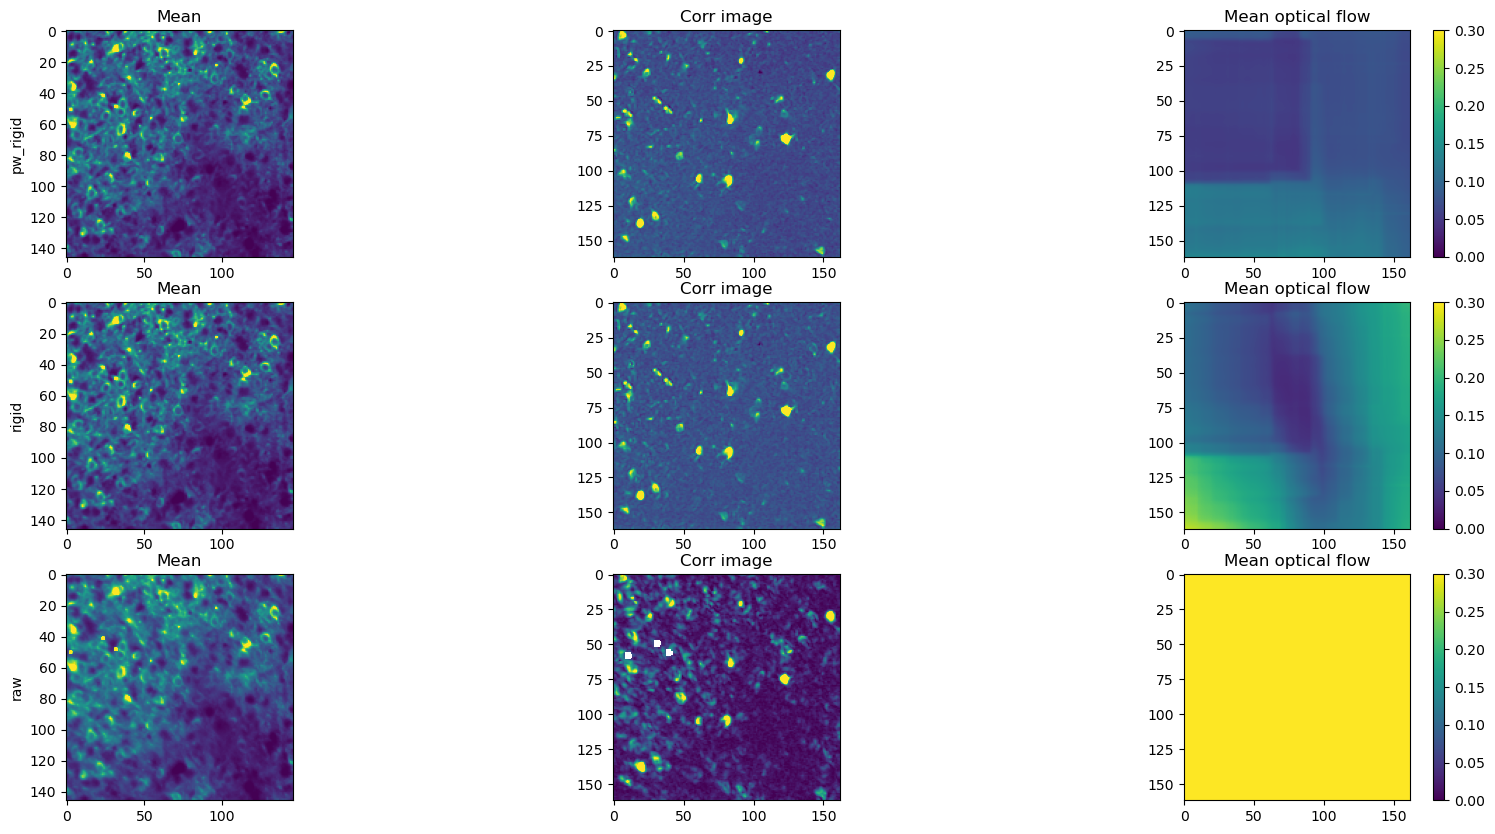

In [20]:
#%% plot the results of Residual Optical Flow
fls = [mc.fname_tot_els[0][:-5] + '_metrics.npz', mc.fname_tot_rig[0][:-5] +
       '_metrics.npz', mc.fname[0][:-4] + '_metrics.npz']

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')      